In [1]:
#imports
import plotly.express as px
import pandas as pd
import numpy as np
import os

Import your groupMetadataID below

In [2]:
#set intial groupMetadataID
gmID = '1bbbfbae-c839-11ee-a7fc-dd032dba19e8'

#if data is stored as .csv file set to False
#else set to True

if os.path.isfile(f"../data/chassis/{gmID}.csv"):
    queryChassis = False
    print("chassis csv file found!")
else:
    queryChassis = True
    print("chassis csv file not found. Query for data necessary.")


if os.path.isfile(f"../data/best_pose/{gmID}.csv"):
    queryPose = False
    print("best_pose csv file found!")
else:
    queryPose = True
    print("best_pose csv file not found. Query for data necessary.")


if os.path.isfile(f"../data/metadata/{gmID}.csv"):
    queryMeta = False
    print("metadata csv file found!")
else:
    queryMeta = True
    print("metadata csv file not found. Query for data necessary.")

chassis csv file found!
best_pose csv file found!
metadata csv file found!


In [3]:
from boto3.dynamodb.conditions import Key,Attr
import boto3

if queryPose or queryChassis or queryMeta:
    dynamodb = boto3.resource('dynamodb')
    table = dynamodb.Table('ads_passenger_processed')
    table_meta =dynamodb.Table('ads_passenger_processed_metadata')

In [4]:
if not os.path.exists(f"../data/best_pose"):
    os.makedirs(f"../data/best_pose")

if queryPose:

    #query arguments for best_pose data
    keywords = dict(
        IndexName='topic-index',
        KeyConditionExpression=Key('topic').eq(
            '/apollo/sensor/gnss/best_pose'),
        ProjectionExpression="groupMetadataID, #t, solStatus, solType, latitudeStdDev, longitudeStdDev, numSatsTracked, numSatsMulti, numSatsInSolution, differentialAge, solutionAge, latitude, longitude",
        Limit=1500,
        ExpressionAttributeNames={'#t': 'time'},
        FilterExpression=Key('groupMetadataID').eq(f'{gmID}')
    )


    #run query for best_pose data and create dataframe
    res = table.query(**keywords)
    df_pose = pd.DataFrame.from_dict(
        pd.json_normalize(res['Items']),orient='columns')

    done = False
    leek = res["LastEvaluatedKey"]

    while not done:
        try:
            leek = res["LastEvaluatedKey"]
            keywords["ExclusiveStartKey"] = leek
            res = table.query(**keywords)
            tmpDF = pd.DataFrame.from_dict(
                pd.json_normalize(res['Items']), orient='columns')
            df_pose = pd.concat([df_pose, tmpDF])
        except KeyError:
            print("Done querying best_pose data")
            done = True

    df_pose.to_csv(f"../data/best_pose/{gmID}.csv")
    print(f"Saved best_pose data at ../data/best_pose/{gmID}.csv")


else:
    df_pose = pd.read_csv(f"../data/best_pose/{gmID}.csv")
    print("Loaded best_pose data")
            
        
print(df_pose.shape)

Loaded best_pose data
(165, 14)


In [5]:
if not os.path.exists(f"../data/chassis"):
    os.makedirs(f"../data/chassis")

if queryChassis:
    
    #query arguments for chassis data
    keywords = dict(
        IndexName='topic-index',
        KeyConditionExpression=Key('topic').eq(
            '/apollo/canbus/chassis'),
        Limit=2000,
        FilterExpression=Key('groupMetadataID').eq(gmID)
    )

    res = table.query(**keywords)
    df_chassis = pd.DataFrame.from_dict(
        pd.json_normalize(res['Items']), orient='columns')

    done = False
    leek = res["LastEvaluatedKey"]

    while not done:
        try:
            leek = res["LastEvaluatedKey"]
            keywords["ExclusiveStartKey"] = leek
            res = table.query(**keywords)
            tmpDF = pd.DataFrame.from_dict(
                pd.json_normalize(res['Items']), orient='columns')
            df_chassis = pd.concat([df_chassis, tmpDF])
            print(leek)

        except KeyError:
            print(f"done querying for chassis data")
            done = True

    df_chassis.to_csv(f"../data/chassis/{gmID}.csv")
    print(f"Saved chassis data at ../data/chassis/{gmID}.csv")
else:
    df_chassis = pd.read_csv(f"../data/chassis/{gmID}.csv")
    print("Loaded chassis data")

print(df_chassis.shape)

Loaded chassis data
(8231, 32)


In [6]:
if not os.path.exists(f"../data/metadata"):
    os.makedirs(f"../data/metadata")

if queryMeta:

    #query arguments for metadata data
    keywords = dict(
        IndexName='groupMetadataID-index',
        KeyConditionExpression=Key("groupMetadataID").eq(gmID),
        ProjectionExpression = "groupMetadataID, #o.Weather, #o.#m, #o.Notes",
        Limit=1500,
        ExpressionAttributeNames={"#o":"other","#m":"Map"},
    )


    #run query for metadata data and create dataframe
    res = table.query(**keywords)
    df_meta = pd.DataFrame.from_dict(
        pd.json_normalize(res['Items']),orient='columns').drop_duplicates()

    df_meta.to_csv(f"../data/metadata/{gmID}.csv")
    print(f"Saved metadata data at ../data/metadata/{gmID}.csv")


else:
    df_meta = pd.read_csv(f"../data/metadata/{gmID}.csv")
    print("Loaded metadata data")
            
        
print(df_meta.shape)

Loaded metadata data
(1, 2)


In [7]:
# read the timeSorted csv
pts = df_chassis.copy()
pts = pts.sort_values('time')
# reduce df to only time and drivingMode
pts = pts[["time", "drivingMode"]]
# function to tell us what state transition it is


def getState(old, new):
    if old == "COMPLETE_AUTO_DRIVE" and new == "COMPLETE_MANUAL":
        return "A->M"
    elif old == "COMPLETE_AUTO_DRIVE" and new == "EMERGENCY_MODE":
        return "A->M"
    elif old == "COMPLETE_MANUAL" and new == "COMPLETE_AUTO_DRIVE":
        return "M->A"
    elif old == "EMERGENCY_MODE" and new == "COMPLETE_AUTO_DRIVE":
        return "M->A"
    else:
        return "NONE"


# we shift the drivingMode column down by 1
pts["shift"] = pts["drivingMode"].shift()
# create transition field
pts['transition'] = (pts["drivingMode"] != pts["shift"])
# set Transition type to NONE for all
pts['transitionType'] = "NONE"
# Set first transition to False, since it was auto True
pts.loc[0, 'transition'] = False
# print(pts['transition'])
# Show counts for transitions
print(pts['transition'].value_counts())
# iterate over all rows and find the ones where transition is true. Then we compare shift and dM to see what
# transition Type we have.
for index, row in pts.iterrows():
    if pts['transition'][index] == True:
        old = pts['shift'][index]
        new = pts['drivingMode'][index]
        pts.loc[index, "transitionType"] = getState(old, new)
print(pts['transitionType'].value_counts())
pts = pts[['time', 'drivingMode', 'transition', 'transitionType']]
pts = pts.sort_values('time')
pts['time'] = pts['time'].astype(float)
pts['time'] = pts['time'].astype('datetime64[ns]')
pts['time'] = pts['time'].astype('datetime64[s]')
pts[['time']]

# show(pts)

transition
False    8221
True       10
Name: count, dtype: int64
transitionType
NONE    8226
A->M       3
M->A       2
Name: count, dtype: int64


time
259  2023-06-07 19:41:03
7720 2023-06-07 19:41:03
5836 2023-06-07 19:41:03
8008 2023-06-07 19:41:03
7300 2023-06-07 19:41:03
...                  ...
7739 2023-06-07 19:43:47
7299 2023-06-07 19:43:47
5997 2023-06-07 19:43:48
1395 2023-06-07 19:43:48
3372 2023-06-07 19:43:48

[8231 rows x 1 columns]

In [8]:
#Convert and sort the time column
bestPose = df_pose.copy()
bestPose = bestPose.sort_values('time')
bestPose['time'] = bestPose['time'].astype(float)
bestPose['time'] = bestPose['time'].astype('datetime64[ns]')
bestPose['time'] = bestPose['time'].astype('datetime64[s]')

#merging best_pose and chassis dataframes
merged_df = pd.merge(pts, bestPose, on='time')

Satellite and Standard Deviation and Work

In [9]:
#Finding the min and max number of satellites in the view
print(f"NumStatsTracked Max: {bestPose['numSatsTracked'].max()}")
print(f"NumStatsTracked Min: {bestPose['numSatsTracked'].min()}")

NumStatsTracked Max: 18
NumStatsTracked Min: 2


In [10]:
#Find the min and max number of satellites being used
print(f"NumStatsInSolution Max: {bestPose['numSatsInSolution'].max()}")
print(f"NumStatsInSolution Min: {bestPose['numSatsInSolution'].min()}")

NumStatsInSolution Max: 17
NumStatsInSolution Min: 0


In [11]:
#Find the max and min number of 4 satellites in a constellation
print(f"NumStatsMulti Max: {bestPose['numSatsMulti'].max()}")
print(f"NumStatsMulti Min: {bestPose['numSatsMulti'].min()}")

NumStatsMulti Max: 17
NumStatsMulti Min: 0


In [12]:
#Determine radius for latitude and longitude 
#x is longitudeStdDev and y is lattitudeStdDev 
#radius is the hypotenuse to determine the distance the points are off from the actual
for index, row in merged_df.iterrows():
    merged_df.loc[index, "radius"] = np.sqrt((merged_df.loc[index,"longitudeStdDev"] ** 2) + (merged_df.loc[index,"latitudeStdDev"] ** 2))

/home/amicco_linux/do-env/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


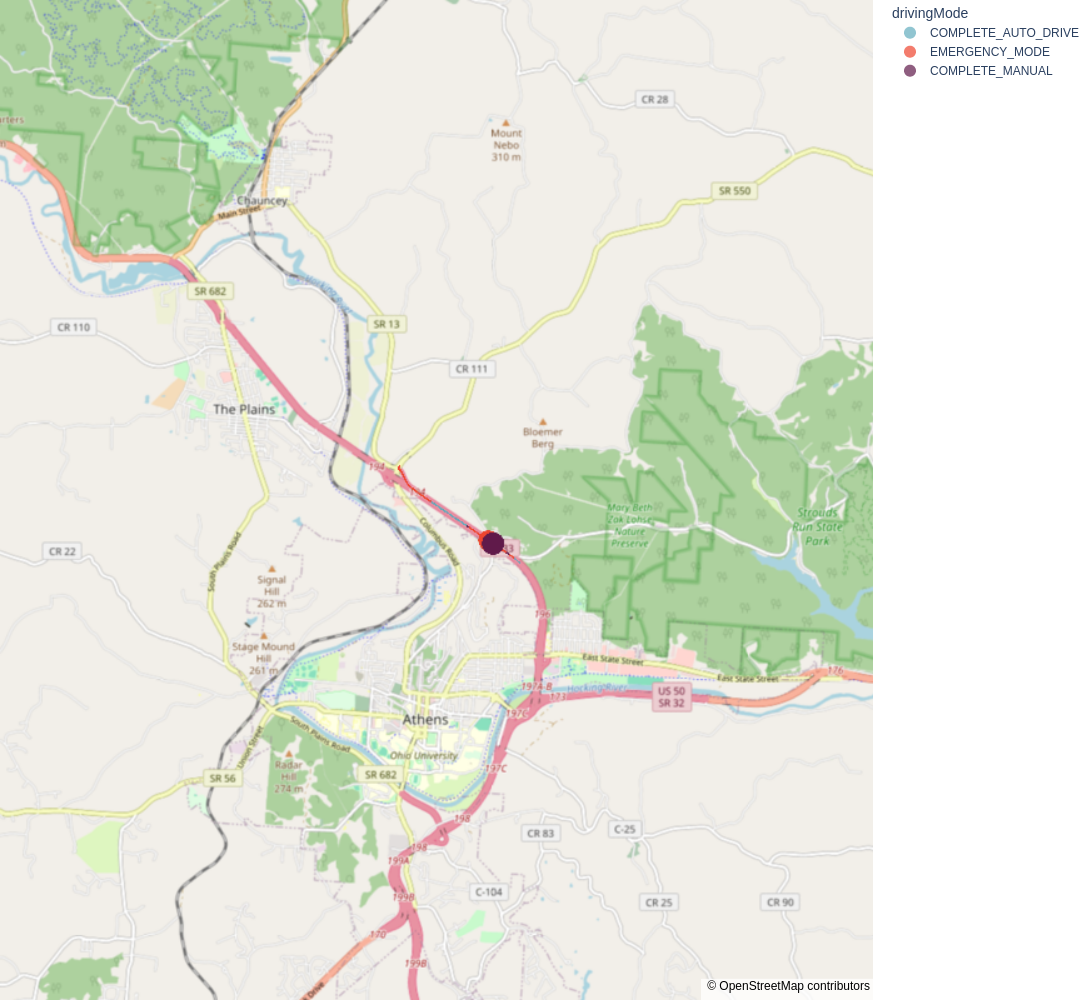

In [13]:
#Mapping driving mode to determine relationship between std dev, numberSatsInSolution and driving mode
fig = px.scatter_mapbox(merged_df, lat="latitude", lon="longitude", hover_name="drivingMode", hover_data=["time","drivingMode", "numSatsInSolution", "solStatus"], 
                        color="drivingMode",
                        size="radius", size_max=16,
                        zoom=12, height=1000, mapbox_style="open-street-map",
                        color_discrete_map={
                             "COMPLETE_MANUAL": "#601A4A",
                             "COMPLETE_AUTO_DRIVE": "#63ACBE",
                             "EMERGENCY_MODE": "#EE442F",
                         })

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

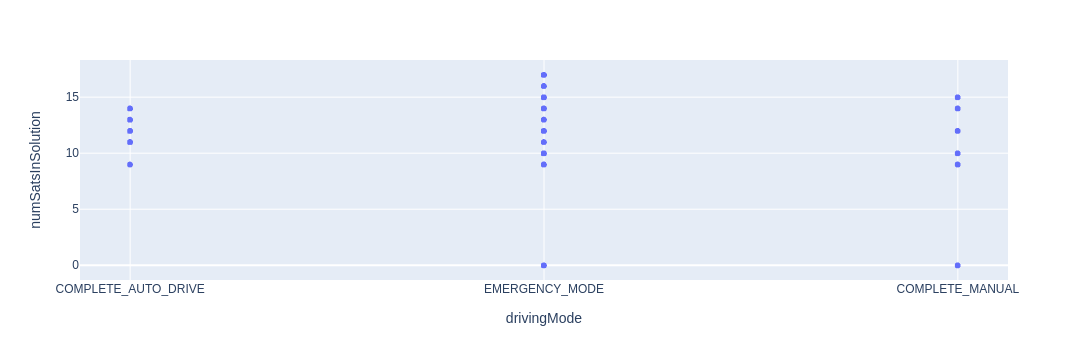

In [14]:
#Scatter plot to show relationship between driving mode and number of satellites
fig = px.scatter(merged_df, x="drivingMode", y="numSatsInSolution")
fig.show()

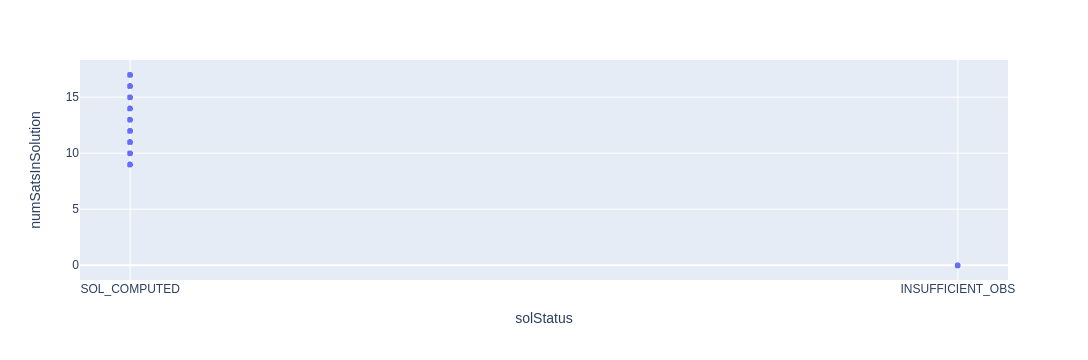

In [15]:
#Showing relationship between the satellite status and the number of satellites. 
fig = px.scatter(merged_df, x="solStatus", y="numSatsInSolution")
fig.show()

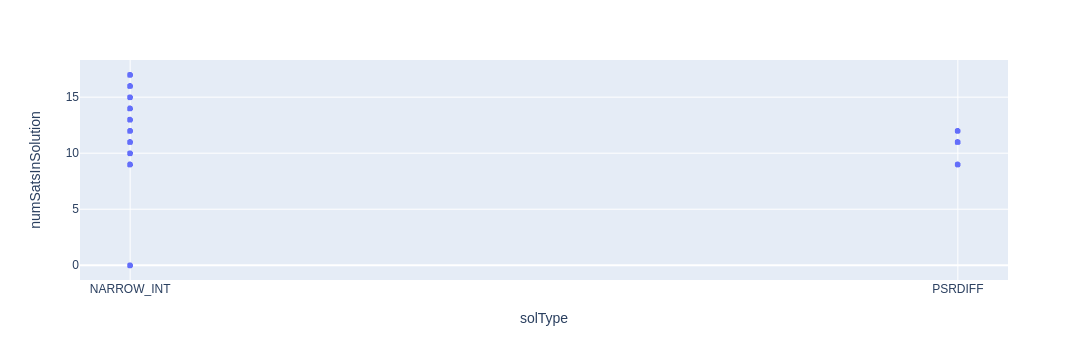

In [16]:
#Showing relationship between the satellite status and the number of satellites. 
fig = px.scatter(merged_df, x="solType", y="numSatsInSolution")
fig.show()